In [1]:
import pandas as pd
import numpy as np
import os.path as op
import functools
import sys

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}   

### Model development

In [16]:
from torch.nn import Module
from torch import nn

class CNN(Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=64, kernel_size=(5, 3), stride = (3,1), padding= (16,1), dilation = (2,1)) 
        self.norm1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(0.01)
        self.pool1 = nn.MaxPool2d(kernel_size = (2,1))
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=(5, 3), stride = 1, padding= (2,1))
        self.norm2 = nn.BatchNorm2d(128)
        self.relu2 = nn.LeakyReLU(0.01)
        self.pool2 = nn.MaxPool2d(kernel_size = (2,1))
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels=256, kernel_size=(5, 3), stride = 1, padding= (2,1))
        self.norm3 = nn.BatchNorm2d(256)
        self.relu3 = nn.LeakyReLU(0.01)
        self.pool3 = nn.MaxPool2d(kernel_size = (2,1))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(46080, 2)
        self.out = nn.Softmax(dim = 1)

    def forward(self, x):
        y = self.conv1(x)
        y = self.norm1(y)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.norm2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = self.conv3(y)
        y = self.norm3(y)
        y = self.relu3(y)
        y = self.pool3(y)
        y = y.view(y.size()[0],-1)
        y = self.dropout(y)
        y = self.fc1(y)
        y = self.out(y)
        return y

net = CNN()
print(net)

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(16, 1), dilation=(2, 1))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
  (norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (pool3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Lin

In [3]:
from torchsummary import summary

summary(net, input_size=(1,64,60), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 60]           1,024
       BatchNorm2d-2           [-1, 64, 30, 60]             128
         LeakyReLU-3           [-1, 64, 30, 60]               0
         MaxPool2d-4           [-1, 64, 15, 60]               0
            Conv2d-5          [-1, 128, 15, 60]         123,008
       BatchNorm2d-6          [-1, 128, 15, 60]             256
         LeakyReLU-7          [-1, 128, 15, 60]               0
         MaxPool2d-8           [-1, 128, 7, 60]               0
            Conv2d-9           [-1, 256, 7, 60]         491,776
      BatchNorm2d-10           [-1, 256, 7, 60]             512
        LeakyReLU-11           [-1, 256, 7, 60]               0
        MaxPool2d-12           [-1, 256, 3, 60]               0
          Dropout-13                [-1, 46080]               0
           Linear-14                   

### Adopt CrossEntropyLoss, Adam optimizer with learning rate 10-5

In [18]:
optimizer = optim.Adam(net.parameters(),lr = 0.00001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = net.to(device)
criterion = criterion.to(device)

In [11]:
test =[]
y_test = pd.DataFrame()
for year in range(2000,2020):
    print(year)
    train = np.memmap(op.join("./img_data/monthly_20d/", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r+').reshape(\
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
    test.append(train)
    label_df_train = pd.read_feather(op.join("./img_data/monthly_20d/", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather"))['Ret_20d']
    y_test= pd.concat([y_test,label_df_train],axis= 0)
test = np.concatenate(test, axis=0, out=None)
test.shape

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


(1502123, 64, 60)

In [12]:
import torch.utils.data as Data
from torch.utils.data import TensorDataset
BATCH_SIZE = 128
def labeling(x):
    if x>0:
        return 0
    else:
        return 1
y_test.columns = ['Ret_20d']
y_test = y_test['Ret_20d'].apply(labeling)
y_test = np.array(y_test).reshape((-1,1))

x_test = torch.Tensor(test)
y_test = torch.Tensor(y_test)

test_loader = Data.DataLoader(dataset=TensorDataset(x_test, y_test), \
                               batch_size=BATCH_SIZE, shuffle=True)

In [15]:
import gc
gc.collect()

141

In [24]:
net.load_state_dict(torch.load('./model/cnn_checkpoint.pt'))
loss_test = []
acc_test = []
prediction = []
y_res = []
for test_step, (b_x,b_y) in enumerate(test_loader):
    b_x = b_x.to(device)
    b_y = b_y.to(device)
    b_y = b_y.reshape(b_y.size()[0],)
    b_x = torch.unsqueeze(b_x,dim=1).float()
    output = net(b_x)
    loss = criterion(output, b_y.reshape(b_y.size()[0],).long())

    pred_y = torch.max(output,1)[1].data
    total_val = b_y.size(0)
    correct_val = (pred_y == b_y).squeeze().sum()
    acc = correct_val/float(total_val)
    
    loss_test.append(loss.item())
    acc_test.append(acc)
    if test_step%100==0:
        print('|Batch|',test_step, '|loss_test|', loss.item(), '|test_acc|', acc)

|Batch| 0 |loss_test| 0.7172368168830872 |test_acc| tensor(0.5469)
|Batch| 100 |loss_test| 0.7197215557098389 |test_acc| tensor(0.5859)
|Batch| 200 |loss_test| 0.7050319910049438 |test_acc| tensor(0.5391)
|Batch| 300 |loss_test| 0.7936943173408508 |test_acc| tensor(0.4297)
|Batch| 400 |loss_test| 0.7536314129829407 |test_acc| tensor(0.5156)
|Batch| 500 |loss_test| 0.7434335350990295 |test_acc| tensor(0.5312)
|Batch| 600 |loss_test| 0.76297926902771 |test_acc| tensor(0.4766)
|Batch| 700 |loss_test| 0.696584939956665 |test_acc| tensor(0.5703)
|Batch| 800 |loss_test| 0.7282213568687439 |test_acc| tensor(0.5312)
|Batch| 900 |loss_test| 0.7502193450927734 |test_acc| tensor(0.4844)
|Batch| 1000 |loss_test| 0.7977944612503052 |test_acc| tensor(0.4062)
|Batch| 1100 |loss_test| 0.7411459684371948 |test_acc| tensor(0.4609)
|Batch| 1200 |loss_test| 0.7153287529945374 |test_acc| tensor(0.5469)
|Batch| 1300 |loss_test| 0.739177942276001 |test_acc| tensor(0.4844)
|Batch| 1400 |loss_test| 0.681302189

In [25]:
np.mean(loss_test)

0.7399745654281744

In [26]:
np.mean(acc_test)

0.5097207

In [28]:
np.mean(acc_test[:1000])

0.50714844

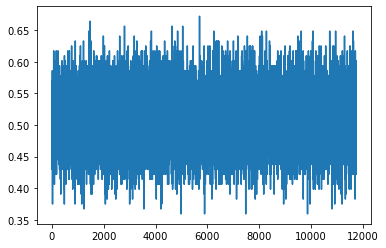

In [29]:
plt.plot(acc_test)